In [1]:
import numpy as np
from numpy import abs, sqrt, log10, sin, cos, exp, cosh, tanh, log, conj, cosh, sinh
np.set_printoptions(precision=16)
from math import pi, factorial
from numpy.random import rand
from numpy.linalg import norm
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg, csc_matrix
import time
from scipy.optimize import minimize
from scipy.special import eval_hermite

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
#mpl.rcParams["figure.dpi"] = 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import pickle

from qonn_cobyla import *

from qutip import *

import matplotlib as mpl

from matplotlib import cm

from numpy import array
from numpy import count_nonzero

from scipy.signal import find_peaks, savgol_filter

In [2]:
def get_wigner(psi):
    '''
    This function gets the Wigner quasiprobability distribution of the pure state psi (in QuTiP).
    '''

    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho @ sp.kron(basis_2[:, j], basis_1)

    rho_1_qutip = Qobj(rho_1)
    xvec = np.linspace(-sqrt(N_p), sqrt(N_p), 200)
    W_1 = wigner(rho_1_qutip, xvec, xvec)

    return W_1

In [3]:
def QFI_explicit(psi):
    '''
    This function calculates the QFI of the pure state psi.
    '''

    psi_phi = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (phi[1] * setup.H_phi() ), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_phi)
    
    psi_delta = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (phi_delta[1] * setup.H_phi() ), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_delta)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/delta**2)[0][0]

    return cost

In [4]:
k = 2
N_e = 2
N_c = 2

phi = [0, pi/3, 0]
delta = 1e-2
phi_delta = [0, pi/3 + delta, 0]

N_p_list = [20, 80]
t_vec = np.linspace(0, 2*pi*1.1, 1000)

QFI_matrix = []

for i_N, N_p in enumerate(N_p_list):

    print('{}/{}'.format(i_N+1, len(N_p_list)))

    setup = Setup(N_e, N_c, N_p, k)

    # Initial state: coherent state (up to an N_p/2 threshold in each mode)
    alpha = sqrt(N_p/4)
    psi_0 = coherent(N_p+1, alpha)

    H = (create(N_p+1)*destroy(N_p+1))**k

    output = sesolve(H, psi_0, t_vec)
    psi_t = output.states

    QFI_matrix.append( np.array([QFI_explicit(tensor(psi, psi).full().reshape(len(tensor(psi, psi).full()))) for psi in psi_t]) )

1/2
2/2


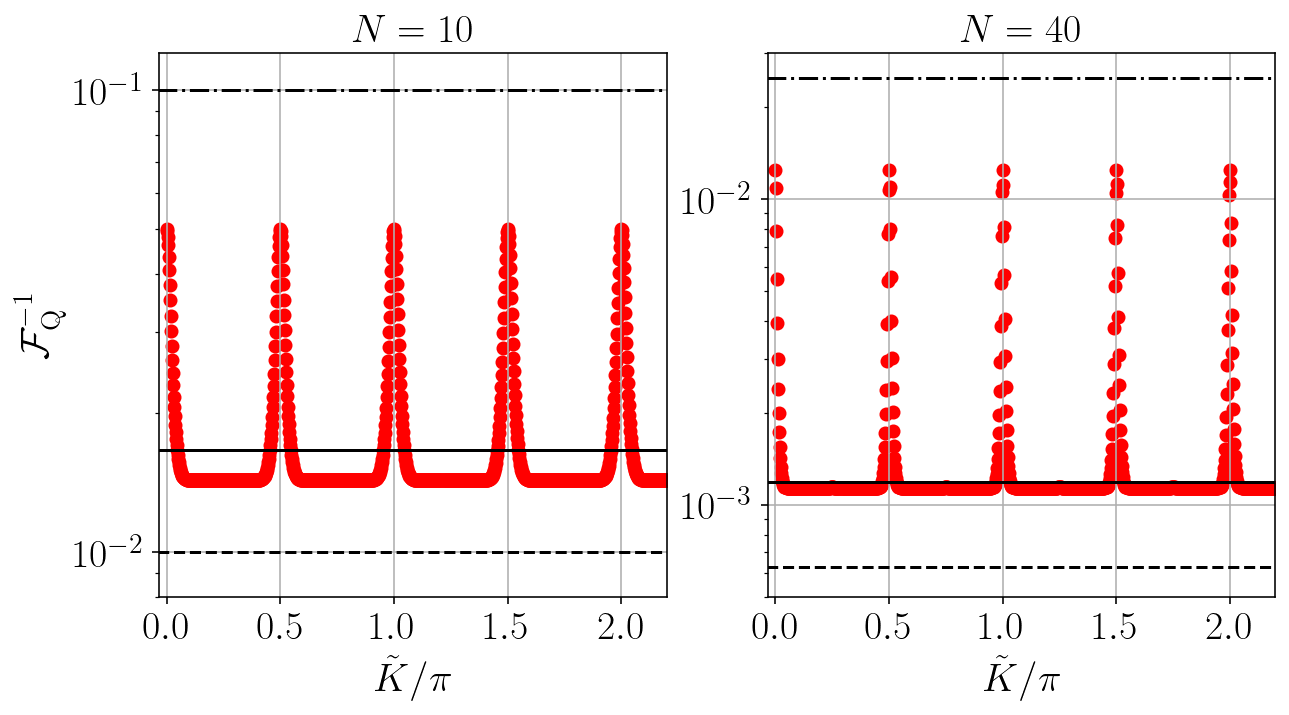

In [11]:
# We plot the ultimate estimation error given by the QFI
plt.rcParams["figure.figsize"] = [5*len(N_p_list), 5]
fig, ax = plt.subplots(1, len(N_p_list))
marker_size = 80
fs = 20

for i_N, N_p in enumerate(N_p_list):

    N = N_p/2

    ax[i_N].grid()
    ax[i_N].set_yscale('log')

    ax[i_N].scatter(t_vec/pi, 1/np.array(QFI_matrix[i_N]), color='r')

    ax[i_N].plot([(min(t_vec)-1)/pi, (max(t_vec)+1)/pi], [1/N, 1/N], '-.k')
    ax[i_N].plot([(min(t_vec)-1)/pi, (max(t_vec)+1)/pi], [2/(N*(N+2)), 2/(N*(N+2))], '-k')
    ax[i_N].plot([(min(t_vec)-1)/pi, (max(t_vec)+1)/pi], [1/N**2, 1/N**2], '--k')

    ax[i_N].set_title(r'$N={:}$'.format(int(N_p/2)), fontsize=fs)
    ax[i_N].set_xlabel(r'$\tilde{K}/\pi$',fontsize=fs)
    ax[i_N].tick_params(axis='both', labelsize=fs)

    ax[i_N].set_ylim(0.8/N**2, 1.2/N)

    ax[i_N].set_xticks(np.arange(0, 2.5, 0.5))
    ax[i_N].set_xlim(-0.1/pi, 2*pi*1.1/pi)

ax[0].set_ylabel(r'$\mathcal{F}^{-1}_{\rm Q}$',fontsize=fs)

#plt.savefig('Figure3_v1_a_b_c.png', bbox_inches='tight', dpi=600)
plt.savefig('Figure3_v1_a_b_c.svg', bbox_inches='tight', dpi=600)

### Time necessary to reach the QFI of TFS

(-0.0001, 0.0001)

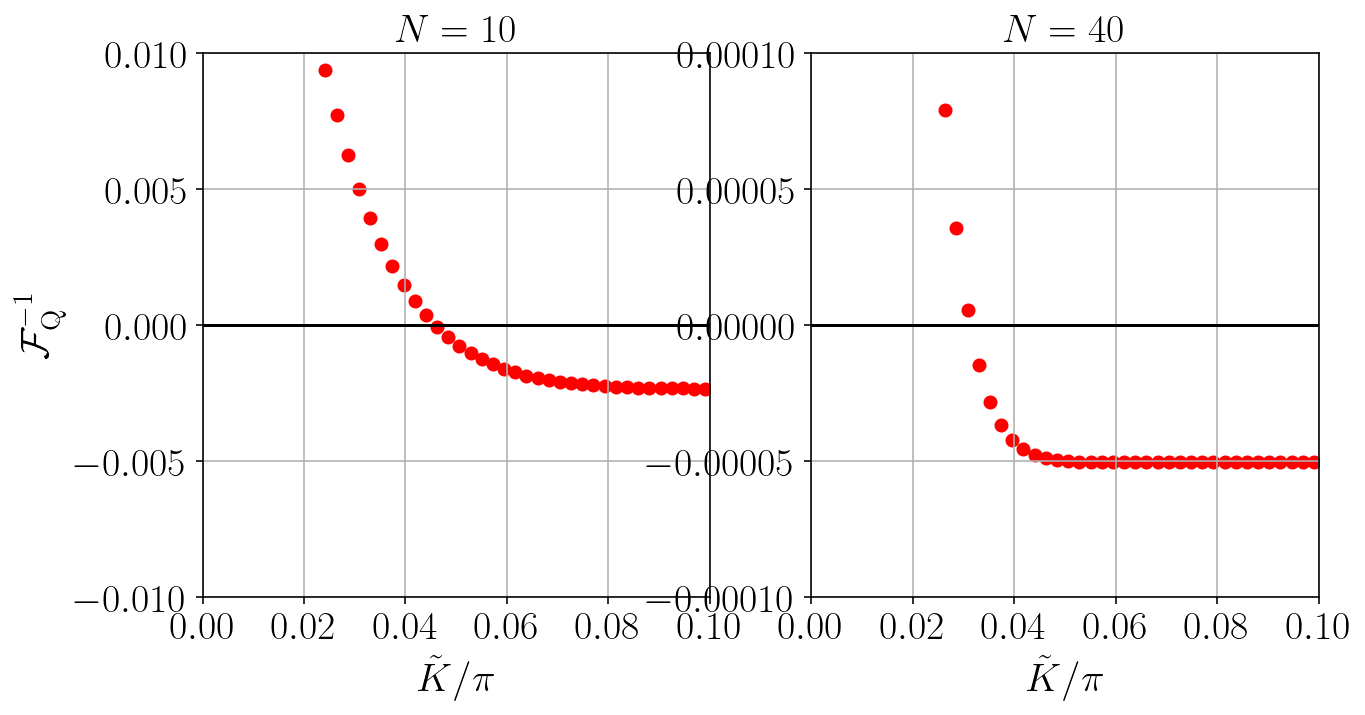

In [9]:
# We plot the ultimate estimation error given by the QFI
plt.rcParams["figure.figsize"] = [5*len(N_p_list), 5]
fig, ax = plt.subplots(1, len(N_p_list))
marker_size = 80
fs = 20

for i_N, N_p in enumerate(N_p_list):

    N = N_p/2
    tfs = 2/(N*(N+2))

    ax[i_N].grid()

    ax[i_N].scatter(t_vec/pi, 1/np.array(QFI_matrix[i_N]) - tfs, color='r')

    ax[i_N].plot([(min(t_vec)-1)/pi, (max(t_vec)+1)/pi], [0, 0], '-k')

    ax[i_N].set_title(r'$N={:}$'.format(int(N_p/2)), fontsize=fs)
    ax[i_N].set_xlabel(r'$\tilde{K}/\pi$',fontsize=fs)
    ax[i_N].tick_params(axis='both', labelsize=fs)

    ax[i_N].set_ylim(-0.01, 0.01)

    ax[i_N].set_xticks(np.arange(0, 2.5, 0.5))
    ax[i_N].set_xlim(-0.1/pi, 2*pi*1.1/pi)

ax[0].set_ylabel(r'$\mathcal{F}^{-1}_{\rm Q}$',fontsize=fs)

for i in range(len(N_p_list)):
    ax[i].set_xlim(0, 0.1)
    ax[i].set_xticks(np.arange(0, 0.12, 0.02))
ax[-1].set_ylim(-0.0001, 0.0001)

#plt.savefig('Figure3_v1_a_b_c.png', bbox_inches='tight', dpi=600)
#plt.savefig('Figure3_v1_a_b_c.svg', bbox_inches='tight', dpi=600)

In [23]:
k = 2
N_e = 2
N_c = 2

phi = [0, pi/3, 0]
delta = 1e-2
phi_delta = [0, pi/3 + delta, 0]

N_p = 20
t_vec = [pi/4, pi/3, pi/2, pi, 2*pi]

setup = Setup(N_e, N_c, N_p, k)

# Initial state: coherent state (up to an N_p/2 threshold in each mode)
alpha = sqrt(N_p/4)
psi_0 = coherent(N_p+1, alpha)
H_int = (create(N_p+1)*destroy(N_p+1))**k

psi_t = [(-1j*t*H_int).expm()*psi_0 for t in t_vec]

xvec = np.linspace(-sqrt(N_p), sqrt(N_p), 200)
W_t = [wigner(psi, xvec, xvec, g=2) for psi in psi_t]

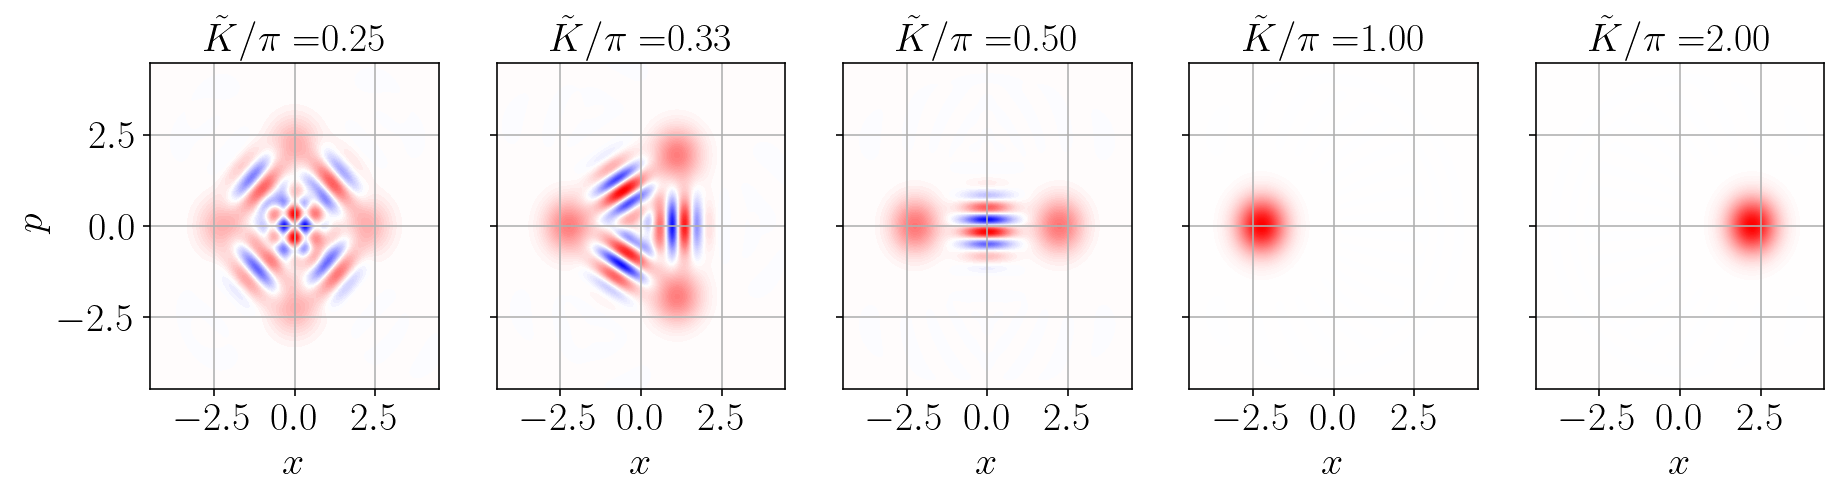

In [26]:
# We plot the Wigner and the Fock space (photon number) distribution
fig, ax = plt.subplots(1, len(t_vec), figsize=(3*len(t_vec), 3))
marker_size = 80
fs = 20

for i_t, t in enumerate(t_vec):

    ax[i_t].grid()

    # Wigner colormap
    wmap = wigner_cmap(W_t[i_t])  # Generate Wigner colormap
    cp = ax[i_t].contourf(xvec, xvec, W_t[i_t], 100, cmap=wmap)
    
    # Standard colormap
    nrm = mpl.colors.Normalize(-W_t[i_t].max(), W_t[i_t].max())
    cp = ax[i_t].contourf(xvec, xvec, W_t[i_t], 100, cmap=cm.bwr, norm=nrm)

    ax[i_t].set_xlabel(r'$x$', fontsize=fs)
    ax[i_t].tick_params(axis='both', labelsize=fs)
    ax[i_t].set_title(r'$\tilde{K}/\pi=$'+'{:.2f}'.format(t/pi), fontsize=fs)

    if i_t>0:
        ax[i_t].set_yticklabels([])

ax[0].set_ylabel(r'$p$', fontsize=fs)

#ax[0].plot([alpha, alpha], [-2.5, 2.5], '--k')

plt.savefig('Figure3_v1_d.png', bbox_inches='tight', dpi=600)